In [ ]:
from google.colab import drive
import sys
import os
drive.mount('/content/drive')

FOLDERNAME = 'models_from_scratch'
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))
%cd /content/drive/My Drive/$FOLDERNAME

from IPython import display

import torch
import torch.nn as nn

Mounted at /content/drive
/content/drive/My Drive/models_from_scratch


## EfficientNet
탄생배경 <br>
model architecture에 대한 연구는 활발히 진행 되어왔지만 해당 모델이 architecture에서 최대의 성능을 내는 것인지 확인하기 어려움 <br>
(ex. VGG, ResNet, GoogLeNet, ...)<br>
ex) ResNet의 경우 최적의 성능을 내는 depth를 어떻게 설정할 것인가? <br>

기존 연구에서 개별 변수(모델 layer의 깊이, input image의 크기(Height X Width), 각 layer의 out channel)에 대한 연구는 진행된 적있지만 이들을 통합적으로 고려한 연구는 진행되지 않았음 <br>

EfficientNet은
> 1) model layer의 width(out channel) <br>
> 2) model layer의 depth <br>
> 3) input image의 resolution(Height x Width) <br>

을 동시에 조절(compound scaling)하여 최적의 조합을 찾고자 함(주어진 컴퓨터 자원하에서) <br>

즉, 목적함수: <br>

$max\ Accuracy(network)$ <br>
(variable: depth, width, resolution) <br>

s.t) <br>
Memory(network) <= target_memory <br>
Flops(network) <= target_flops <br>
cf) flops: 초당 부동소수점 연산 <br>
<br>
notebook 진행 순서 <br>

1) base model 생성 (EfficientNet-B0) <br>
> MobileNet v2 설명, 일부 구현<br>
> SENet 설명, 구현<br>

2) compound scaling

## Ref
1. Efficient Net <br>
  paper: https://arxiv.org/abs/1905.11946<br>
  
  official PyTorch code: https://github.com/pytorch/vision/blob/main/torchvision/models/efficientnet.py

  how to make EfficientNet with PyTorch(Youtuber: 
Aladdin Persson): https://www.youtube.com/watch?v=fR_0o25kigM&list=PLhhyoLH6IjfxeoooqP9rhU3HJIAVAJ3Vz&index=20 <br>

  blog: https://lynnshin.tistory.com/53, https://lynnshin.tistory.com/13<br>

  architecture picture: https://www.researchgate.net/figure/The-structure-of-an-EfficientNetB0-model-with-the-internal-structure-of-MBConv1-and_fig2_351057828 <br>

2. Mobile Net v2 <br>
  paper: https://arxiv.org/abs/1801.04381<br>
  blog(depthwise conv): https://coding-yoon.tistory.com/122 <br>

3. SE Net <br>
  paper: https://arxiv.org/abs/1709.01507<br>
  blog: https://deep-learning-study.tistory.com/539 <br>

Efficient Net의 경우 base model을 생성하기 위해 <br>
1) Moblie Net v1, v2에서 소개된 depth wise convolution, inverted residual connnection <br>
2) SENet <br>
3) Stochastic Depth(생략) <br>
을 구현할 줄 알아야 합니다. <br>

## Mobile Net v2
모바일 기기(ex.스마트폰) 환경에서 deep learning을 구현하기 위해 고안된 Mobile net의 version 2 <br>
* 특징 <br>
1) 모바일 환경에서 작동해야하는 만큼 메모리 부하가 적어야 한다. <br>
2) 적은 computing 자원으로도 빠르게 결과를 도출해야 한다. <br>
 -> 연산 효율성 극대화

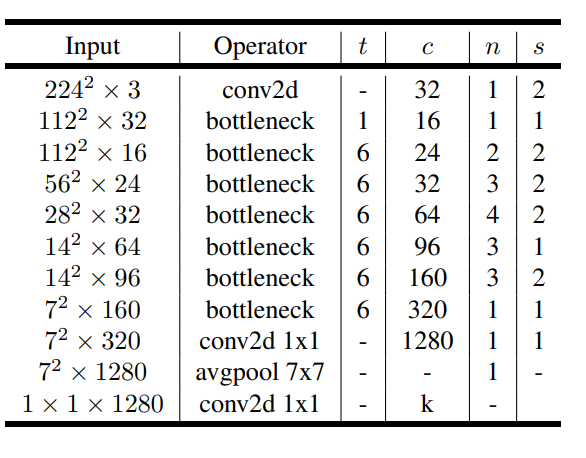

In [ ]:
# from mobilenetv2 paper table 2 (overview of mobile net v2 architecture)
display.Image(os.path.join(os.getcwd(), 'pic/overview_mobilenet_v2.png'))

MobileNet v2에서 모르실만한 모듈은 bottleneck일 것입니다. <br>
bottleneck module은 다음과 같이 이루어져 있습니다.

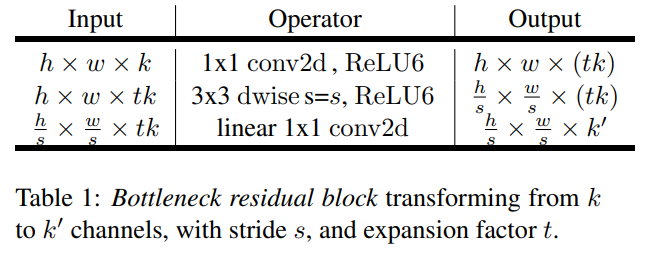

In [ ]:
# from mobilenetv2 paper table 1 (architecture of bottleneck)
display.Image(os.path.join(os.getcwd(), 'pic/bottleneck.png'))

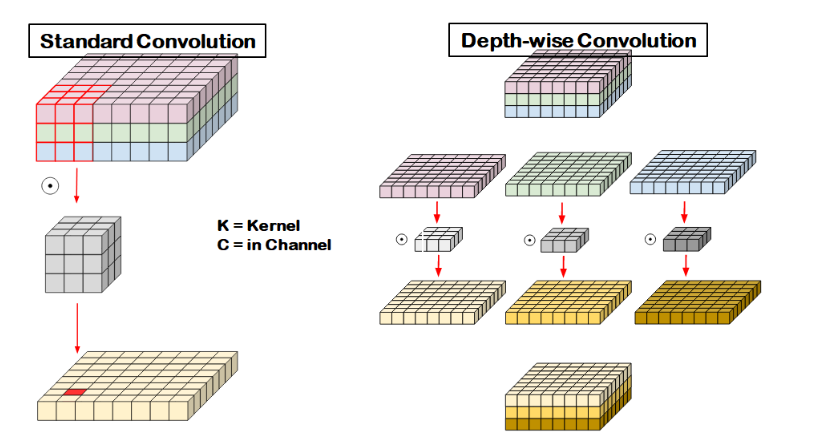

In [ ]:
# 여기서 dwise는 depthwise conv을 뜻하는 것으로 먼저 이미지를 통해
# 해당 layer의 연산이 어떻게 진행되는지 살펴보겠습니다. (from: https://coding-yoon.tistory.com/122)
display.Image(os.path.join(os.getcwd(), 'pic/depthwise_conv.png'))

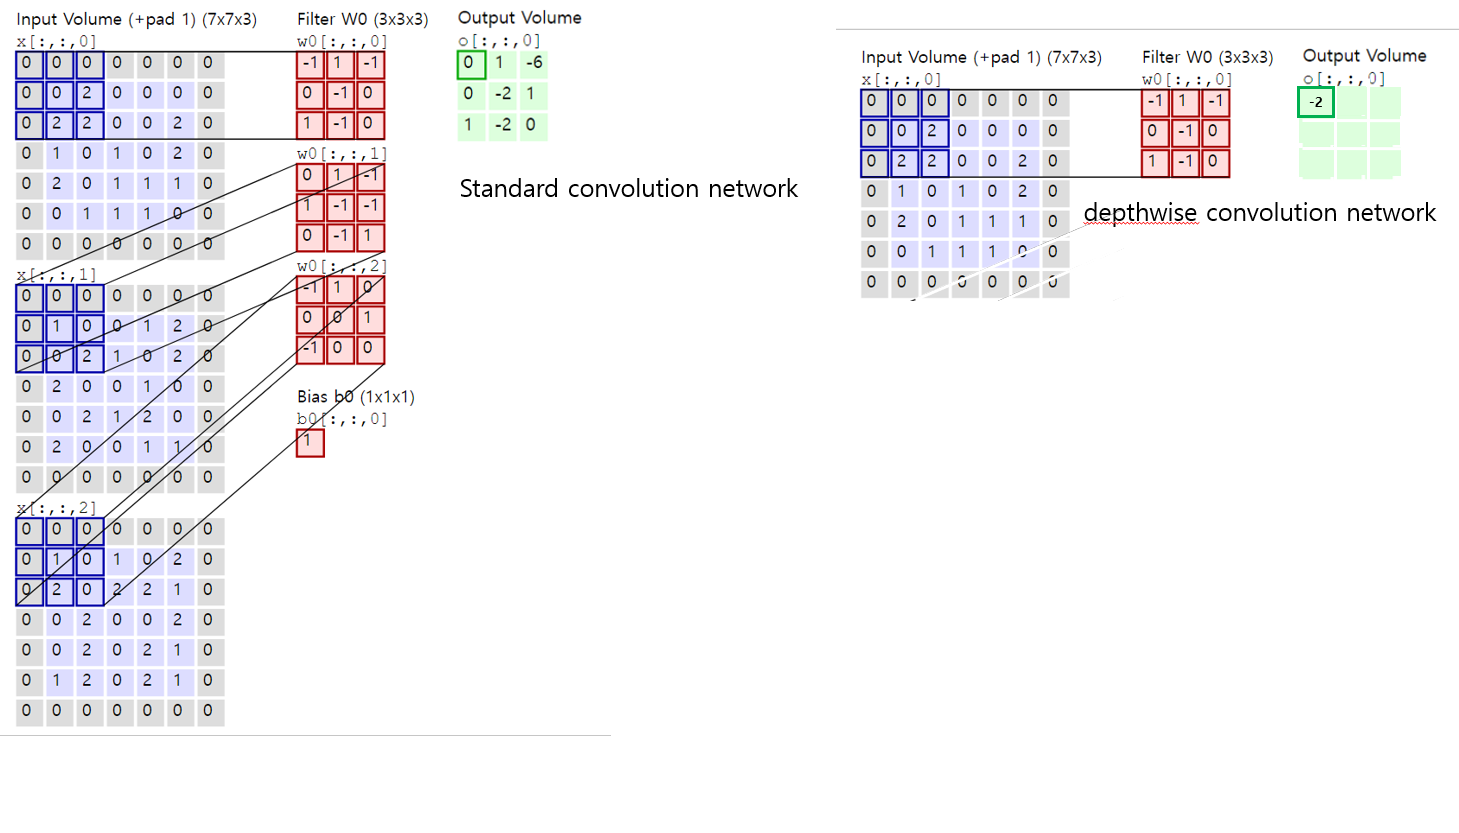

In [ ]:
# from https://cs231n.github.io/convolutional-networks/
display.Image(os.path.join(os.getcwd(), 'pic/depthwise.png'), height = 700)

## depthwise conv
기존의 conv net의 경우 input(C, H, W)의 모든 C(channel)에 대해 weight sum을 진행. <br>
반면 depthwise conv net의 경우 input(C, H, W)를 각 C(channel)로 쪼갠 후(1, H, W) <br>
convolution 연산 진행, 결과값 concat
```python
# psudo code
def conv():
  '''
  input(Tensor[N, C, H, W]) (N: num_imgs, C: channels, H: height, W: width)
  filter(Tensor[F, C, HH, WW]) (F: num_filters, C: channels, HH: filter height, WW: filter width)
  '''
  one_feature_map
  while:
    sum(input[N, :, stride:stride+HH, stride:stride+WW] * filter[F, :, :, :])
    slide window(stride)

def depthwise_conv():
  one_feature_map
  while:
    output[i] = sum(input[N, i, stride:stride+HH, stride:stride+WW] * filter[F, i, :, :])
    slide window(stride)

```
Why depthwise conv? <br>
기존 conv의 경우 하나의 feature map을 계산하기 위해 <br>
kernel_size * kernel_size * in_channels의 parameters 필요. <br>

반면 depthwise conv의 경우 <br>
kernel_size * kernel_size의 parameters 필요 <br>

-> 연산량 효율적 감소



In [ ]:
class depth_wise_conv(nn.Module): # we will not use this module. It's just for explanation
  def __init__(self, in_channels = 3, kernel_size = 3, stride = 2):
    super(depth_wise_conv, self).__init__()
    '''
    spilt input tensor into [N, 1, H, W]
    and then apply conv(In_channels = 1, out_chacnnels = 1)
    last concat outputs
    input
      - input_tensor: Tensor[N, C, H, W] 
      - kernel_size(int)
    output
      - concat((Tensors), dim = 1))
        * Tensors(List): [Tensor[N, 1, H', W'], Tensor[N, 1, H', W'], ...]
        * len(Tensors) = C
    '''
    if kernel_size == 3:
      padding = 1
    elif kernel_size == 5:
      padding = 2
    self.convs = nn.ModuleList([nn.Conv2d(in_channels = 1,
                                out_channels = 1,
                                kernel_size = kernel_size,
                                stride = stride,
                                padding = padding,
                                bias = False) for i in range(in_channels)]) # conv2d groups keyward를 통해 쉽게 depth wise conv 가능

  def forward(self ,x):
    x_split = torch.split(x, 1, dim=1)
  
    output = [conv(x_split[i]) for i, conv in enumerate(self.convs)]

    return torch.cat(output, dim = 1)

In [ ]:
x = torch.randn(1, 3, 224, 224)

model = depth_wise_conv(3)
depth_wise_groups = nn.Conv2d(in_channels = x.size(1), # groups keyword를 활용한 depthwise conv net
                             out_channels = x.size(1),
                             kernel_size = (3, 3),
                             stride = 2,
                             padding = 1,
                             groups = x.size(1),
                             bias = False)

In [ ]:
with torch.no_grad():
  for i in range(x.size(1)):
    depth_wise_groups.weight[i] = model.convs[i].weight  # for matching each of conv parameters

out = model(x)
correct_out = depth_wise_groups(x)

In [ ]:
torch.equal(out, correct_out) 

True

In [ ]:
class depth_wise_conv(nn.Module): 
  def __init__(self, in_channels = 3, kernel_size = 3, stride = 2):
    super(depth_wise_conv, self).__init__()
    '''
    inputs
      - input_tensor: Tensor[N, C, H, W]
      - kernel_size(int)
      - stride(int)
    outputs
      - Tensor[N, C, H, W]
    '''
    if kernel_size == 3:
      padding = 1
    elif kernel_size == 5:
      padding = 2
    self.conv = nn.Conv2d(in_channels = in_channels,
                           out_channels = in_channels,
                           kernel_size = kernel_size,
                           stride = stride,
                           padding = padding,
                           groups = in_channels)

  def forward(self ,x):
    return self.conv(x)

## depthwise separable conv
두 개의 module로 구성 <br>
1) depthwise conv <br>
2) pointwise conv(1x1 conv) <br>
(1x1 conv)의 경우 주로 input tensor의 channel을 변경하고자 할 때 많이 사용 <br>
pointwise conv의 경우 연산량이 매우 적고 depthwise conv의 경우 상대적으로 더 연산량이 많음. <br>

* depthwise separable conv 목적 <br>
이에 따라 pointwise conv을 이용해 연산량을 최대한 줄이고 depthwise conv을 통해 feature 추출

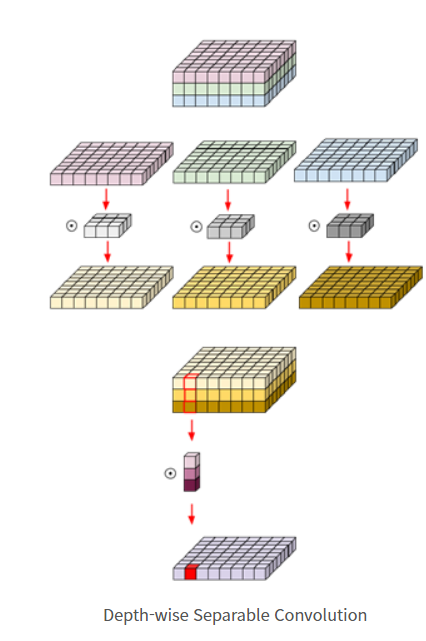

In [ ]:
# from: https://coding-yoon.tistory.com/122
display.Image(os.path.join(os.getcwd(), 'pic/depthwise_separable.png'))

In [ ]:
class pointwise_conv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.pointwise = nn.Conv2d(in_channels = in_channels,
                               out_channels = out_channels,
                               kernel_size = (1, 1),
                               stride = 1)
  def forward(self, x):
    return self.pointwise(x)

## Inverted Residual Block




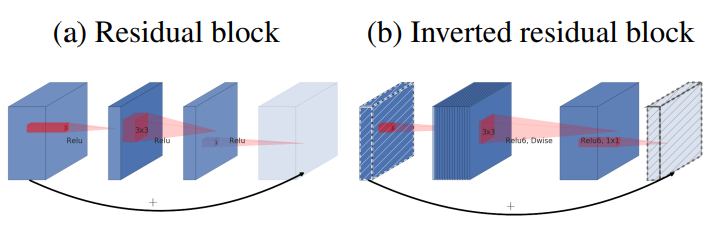

In [ ]:
# from mobilenetv2 paper figure 3
display.Image(os.path.join(os.getcwd(), 'pic/inverted_residual_block.png'))

기존의 residual block의 경우 <br>
(wide -> narrow -> wide) <br>
> input의 channel 감소 (1x1 conv) & activation <br>
> conv & activation <br>
> channel 증가(1x1 conv) & activation<br>
> skip connection (x+=identity) <br>

inverted residual block <br>
(narrow -> wide -> narrow) 
> input channel 증가 & activation<br>
> conv & activation <br>
> channel 감소 (1x1 conv) & activation<br>
> skip connection (x+=identity) <br>
-> 목적: 더 적은 channel의 tensor를 connection 함으로써 연산량 감소



In [ ]:
class linear_bottleneck(nn.Module):
  def __init__(self, in_channels, expansion, out_channels, stride):
    super().__init__()
    self.in_channels = self.in_channels
    self.out_channels = self.out_channels
    self.stride = stride

    self.pointwise = pointwise_conv(in_channels, expansion)
    self.depth_wise_conv = depth_wise_conv(in_channels = expansion, kernel_size = 3, stride = stride)  
    self.proj = pointwise_conv(expansion, out_channels)
  def forward(self, x):
    identity = x
    x = self.pointwise(x)
    x = self.depth_wise_conv(x)
    x = self.proj(x)
    # inverted residual block
    if self.in_channels == self.out_channels and self.stride == 1:
      x += identity
    return x

## SENet(Squeeze-and-Excitation Networks)
탄생 배경 <br>
기존 conv net의 경우 input tensor(C, H, W)에 대해 각 필터(Filter(C, H', W'))를 weight sum하므로 모든 channel의 정보가 하나로 담겨집니다.
```python
def conv(input):
  '''
  input(Tensor[N, C, H, W])
  filter(Tensor[F, C, HH, WW])
  '''
  while:
    sum(input[N, :, stride:stride+HH, stride:stride+WW] * filter[F, :, :, :])
    slide window(stride)
```
따라서 각 channel간의 상호작용에 대한 정보가 명시적(explicitly)으로 담기지 않게됩니다. <br>
이를 명시적으로 담기 위해 각 채널에 대한 정보를 압축한 후 excitation하여 Input tensor에 곱합니다.<br>


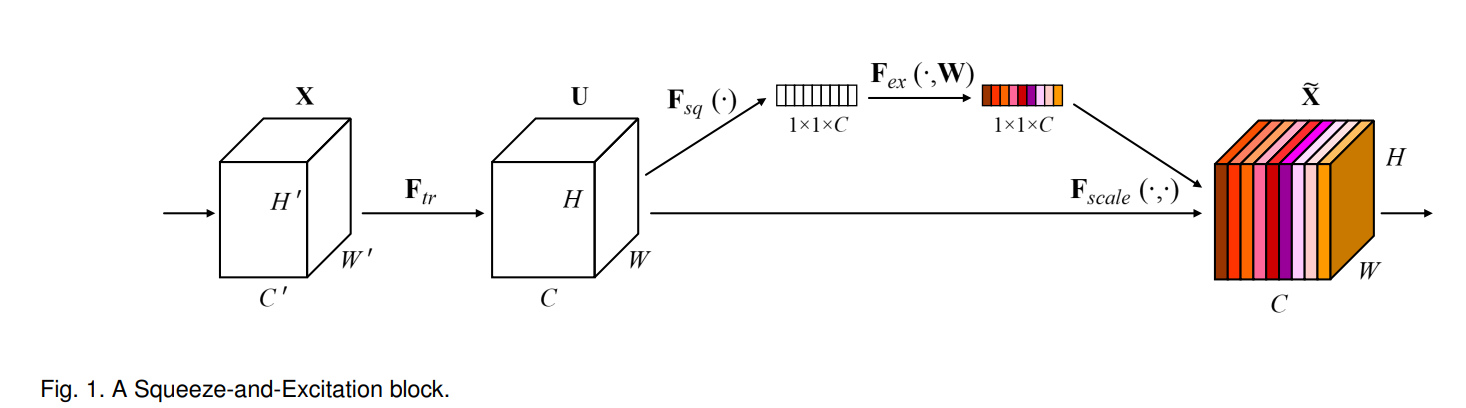

In [ ]:
# from SENet paper fig.1
display.Image(os.path.join(os.getcwd(), 'pic/SE_block.png'))

>1) 먼저 Squeeze layer를 통해 이전 layer를 거친 feature tensor(H, W, C)를 (1, 1, C)로 압축한 후 <br>
>2) Excitaiton layer를 통해 압축된 tensor에 projection & activation function을 적용합니다. <br>
>3) 해당 결과값(1, 1, C)을 feature tensor(H, W, C)에 곱합니다

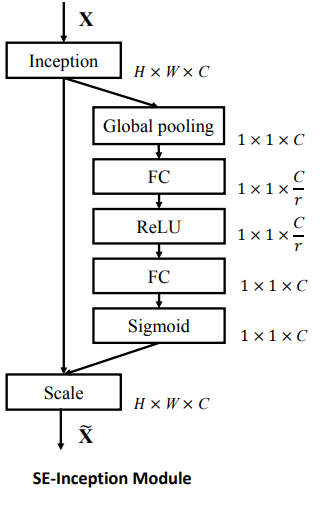

In [ ]:
# detail architecture of SENet(base model: Inception Net(GoogLeNet)) from SENet paper
display.Image(os.path.join(os.getcwd(), 'pic/SENet.png'))

## Squeeze
```python
# psudo code
def Squeeze():
  inputs:
    feature(Tensor[N, C, H, W])
  returns:
    output(Tensor[N, C, 1, 1])
```

1. Squeeze를 위해 무조건 Average pool 사용? <br>
저자는 maxpool과 average pool을 실험에 사용했지만 Average pool이 더 좋은 성능을 보이는 것을 확인. <br>
(SENet paper TABLE 11 참조) <br>
모델마다 적합한 Squeeze 방법론이 다를 수 있으므로 실험 또는 이론적으로 다른 알고리즘을 적용해보고 특별한 경우가 아닐 경우 average pool 적용 <br>

## Excitation
(1, 1, C) -> (1, 1, C/r) -> (1, 1, C) <br>
```python
# psudo code
def Excitation():
  Linear(C, C/r)
  relu()
  Linear(C/r, C)
  sigmoid()
```
1. Why Excitation(Linear & activation) module 적용? <br>
1) feature의 pooling 값을 그냥 곱할 경우 학습이 적절하게 되지 않을 가능성. <br>
즉 적절한 learnable parameter 필요 <br>
2) 각 채널간의 상호작용에 대한 정보 필요 <br>
  -> fully connected layer and activation function <br>
2. Why channel reduction(r)?<br>
1) 연산량을 줄이기 위해<br>
2) 일반화를 위해 <br>

```python
# psudo code
def SENet():
  SE_block = (squeeze & excitation) # SE_block: 각 채널의 상호작용에 대한 정보 
  return x * SE_block(x)
```

In [ ]:
class squeeze(nn.Module):
  def __init__(self):
    super(squeeze, self).__init__()
    self.GAP = nn.AdaptiveAvgPool2d((1, 1))

  def forward(self, x):
    return self.GAP(x)

In [ ]:
class excitation(nn.Module):
  def __init__(self, in_channels, r = 4):
    '''
    inputs
      - in_channels
      - r(int): channel reduction ratio
    '''
    super(excitation, self).__init__()
    self.block = nn.Sequential(
        nn.Conv2d(in_channels = in_channels,
                  out_channels = int(in_channels/r),
                  kernel_size = (1, 1),
                  stride = 1),
        nn.ReLU(), 
        nn.Conv2d(in_channels = int(in_channels/r),
                  out_channels = in_channels,
                  kernel_size = (1, 1),
                  stride = 1),
        nn.Sigmoid()
    )
    
  def forward(self, x):
    return self.block(x)

In [ ]:
class SENet(nn.Module):
  def __init__(self, in_channels, r = 4):
    super(SENet, self).__init__()
    self.SE_block = nn.Sequential(
        squeeze(),
        excitation(in_channels, r)
    )

  def forward(self, x):
    output = self.SE_block(x)
    return x * output

In [ ]:
x = torch.randn(1, 128, 7, 7)
model = SENet(in_channels = 128, r = 4)
output = model(x) # output.size() = (1, 128, 7, 7)
output.size()

torch.Size([1, 128, 7, 7])

##Efficient Net base model(EfficientNetB0)

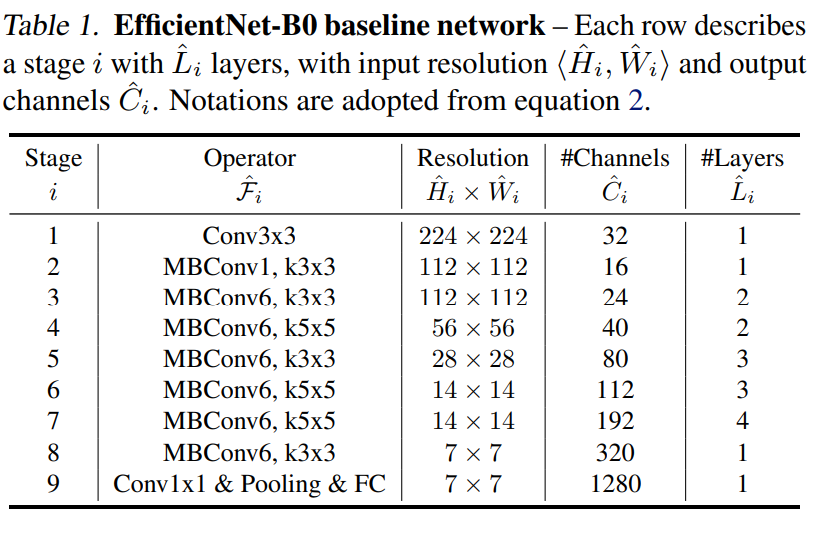

In [ ]:
# architecture of base model b0 (from EfficientNet paper table 1)
display.Image(os.path.join(os.getcwd(), 'pic/EfficientNetB0_table1.png'))

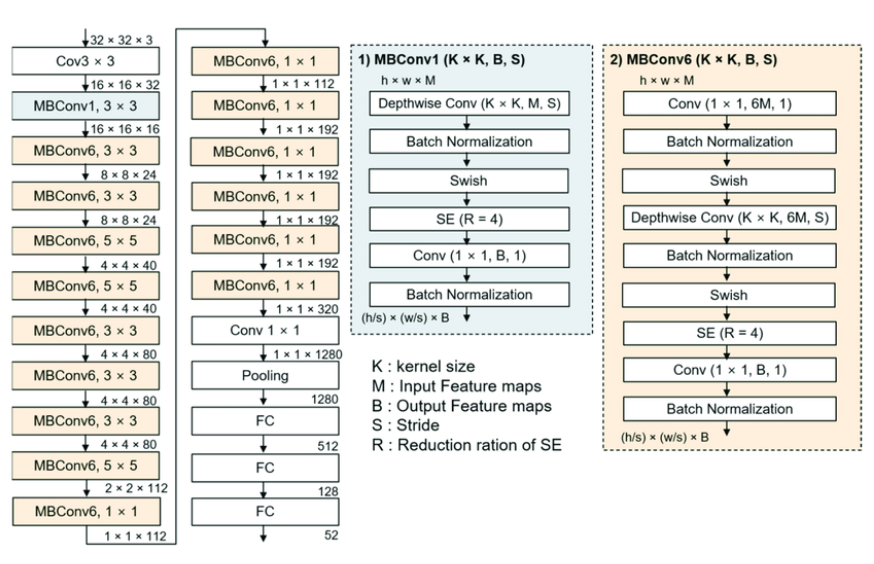

In [ ]:
# detail architecture of base model from https://www.researchgate.net/figure/The-structure-of-an-EfficientNetB0-model-with-the-internal-structure-of-MBConv1-and_fig2_351057828
display.Image(os.path.join(os.getcwd(), 'pic/detail_EfficientNet.png'))

## EfficidentNet-B0 basline network
위의 모델 architecture에 따라 EfficientNet-B0를 설계하고자 할 때, <br>

1. MBConv의 kernel_size가 가변적으로 변하므로 kernel_size를 변수로 설정 <br>

2. MBConv1과 MBConv6 두 모듈을 나눠서 설계한다. <br>

3. 각 layer의 결과값을 살펴보면 output의 resolution(H*W)을 결정짓는 것은 MBConv 내의 depthwise conv이다. <br>

  conv layer의 resolution은 크게 kenel_size, stride, padding에 영향을 받는다. <br>
  여기서 layer output을 살펴보면 kerenl_size에 따라 resolution이 결정되지 않는다.<br>
  또한 해당 모델에서 padding은 resolution을 유지하는 역할을 하므로 stride를 통해 image의 resolution을 제어한다. <br>
  cf) $w' = 1 + (w-kernel\ size + 2*padding)/(2*stride)$ <br>
  (w: width, w': width after conv, in case of no dilation )

4. MBConv block의 경우 #layer가 1 이상이 가능하다. 따라서, <br>
1) 처음 MBconv layer의 경우 in channel을 이전 MBConv layer의 out channel로 설정 <br>
2) 다음 layer에서 kenrel size 유지(stride: 1), in channel = out channel
```python
# psudo code
class EfficientNetB0(nn.Module):
  def __init__(self):
    super(EfficientNetB0, self).__init__()
    
    self.stage_1 = conv3x3(stride:1, in_channels = 3, out_channels = 32)
    self.stage_2 = MBConv1_3x3(stride:2, in_channels = 32, out_channels = 16)
    self.stage_3 = [MBConv6_3x3(stride:1, in_channels = 16, out_channels = 24),
    MBConv6_3x3(stride:1, in_channels = 24, out_channels = 24]
    self.stage_4 = [MBConv6_5x5(stride:2, in_channels = 24, out_channels = 40),
    MBConv6_5x5(stride:1, in_channels = 40, out_channels = 40]
    self.stage_5 = [MBConv6_3x3(stride:2, in_channels = 40, out_channels = 80,
    MBConv6_3x3(stride:1, in_channels = 80, out_channels = 80),
    MBConv6_3x3(stride:1, in_channels = 80, out_channels = 80)]
    self.stage_6 = [
    MBConv6_5x5(stride:2, in_channels = 80, out_channels = 112),
    MBConv6_5x5(stride:1, in_channels = 112, out_channels = 112),
    MBConv6_5x5(stride:1, in_channels = 112, out_channels = 112)]
    
    ...

    self.stage_9 = [
      conv1x1,
      pool,
      flatten,
      fc
    ]
  def forward(self, x):
    for stage:
      x = self.stage(x)
    return x
```


In [ ]:
class Swish(nn.Module): # search torch.nn.SiLU()
  def __init__(self):
    super(Swish, self).__init__()
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    return x * self.sigmoid(x)

In [ ]:
class MBConv1(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, stride, r = 4):
    '''
    inputs:
      - in_channels(int)
      - out_channels(int)
      - kernel_size(int): 3: will get padding 1, 5: will get padding 5 in depth wise conv
      - stride(int): 1: will retrun same resolution(H*W), 2: will return resolution/4 (H/2 * W/2)
      - r(int): channel reduction ratio of SENet
    returns:
      - MBConv1
    '''
    super(MBConv1, self).__init__()
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.stride = stride
    self.block = nn.Sequential(
     depth_wise_conv(in_channels = in_channels, 
                     kernel_size = kernel_size,
                     stride = stride),
     nn.BatchNorm2d(num_features = in_channels),
     Swish(),
     SENet(in_channels = in_channels, r = 4),
     nn.Conv2d(in_channels = in_channels,
               out_channels = out_channels,
               kernel_size = (1, 1),
               stride = 1),
      nn.BatchNorm2d(num_features = out_channels)
    )

  def forward(self, x):
    '''
    input:
      -  x(Tensor[N, in_C, H, W])
    return:
      -  x(Tensor[N, out_C, H', W']): stride 1: H', W' = H, W | stride 2: H', W' = H/2, W/2
    '''
    # inverted residual block
    if self.in_channels == self.out_channels and self.stride == 1:
      identity = x
      x = self.block(x) 
      x += identity
    else:
      x = self.block(x)

    return x

In [ ]:
class MBConv6(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, stride, r = 4):
    '''
    inputs:
      - in_channels(int)
      - out_channels(int)
      - kernel_size(int): 3: will get padding 1, 5: will get padding 5 in depth wise conv
      - stride(int): 1: will retrun same resolution(H*W), 2: will return half resolution(H/2 * W/2)
      - r(int): channel reduction ratio of SENet
    returns:
      - MBConv6 (6 means channel expansion)
    '''
    
    super(MBConv6, self).__init__()
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.stride = stride
    self.block = nn.Sequential(
     nn.Conv2d(in_channels = in_channels,
               out_channels = 6*in_channels,
               kernel_size = (1, 1),
               stride = 1),
     nn.BatchNorm2d(num_features = 6*in_channels),
     Swish(),
     depth_wise_conv(in_channels = 6*in_channels, 
                     kernel_size = kernel_size, 
                     stride = stride),
     nn.BatchNorm2d(num_features = 6*in_channels),
     Swish(),
     SENet(in_channels = 6*in_channels, r = 4),
     nn.Conv2d(in_channels = 6*in_channels,
               out_channels = out_channels,
               kernel_size = (1, 1),
               stride = 1),
      nn.BatchNorm2d(num_features = out_channels)
    )

  def forward(self, x):
    '''
    input:
      -  x(Tensor[N, in_C, H, W])
    return:
      -  x(Tensor[N, out_C, H', W']): stride 1: H', W' = H, W | stride 2: H', W' = H/2, W/2
    '''

    # inverted residual block
    if self.in_channels == self.out_channels and self.stride == 1:
      identity = x
      x = self.block(x) 
      x += identity 
    else:
      x = self.block(x)

    return x

In [ ]:
class EfficientNet(nn.Module):
  def __init__(self, img_channels, num_classes):
    super(EfficientNet, self).__init__()
    self.stage_1 = nn.Conv2d(in_channels = img_channels,
                          out_channels = 32,
                          kernel_size = (3, 3),
                          stride = 1,
                          padding = 1)
    
    self.stage_2 = MBConv1(in_channels = 32,
                           out_channels = 16,
                           kernel_size = 3,
                           stride = 2)
    
    self.stage_3 = [MBConv6(in_channels = 16,
                           out_channels = 24,
                           kernel_size = 3,
                           stride = 1),
                    MBConv6(in_channels = 24,
                            out_channels = 24,
                            kernel_size = 3,
                            stride = 1)]
    self.stage_3 = nn.Sequential(*self.stage_3)

    self.stage_4 = [MBConv6(in_channels = 24,
                            out_channels = 40,
                            kernel_size = 5,
                            stride = 2),
                    MBConv6(in_channels = 40,
                            out_channels = 40,
                            kernel_size = 5,
                            stride = 1)]
    self.stage_4 = nn.Sequential(*self.stage_4)

    self.stage_5 = [MBConv6(in_channels = 40,
                            out_channels = 80,
                            kernel_size = 3,
                            stride = 2),
                    MBConv6(in_channels = 80,
                            out_channels = 80,
                            kernel_size = 3,
                            stride = 1),
                    MBConv6(in_channels = 80,
                            out_channels = 80,
                            kernel_size = 3,
                            stride = 1)]
    self.stage_5 = nn.Sequential(*self.stage_5)

    self.stage_6 = [MBConv6(in_channels = 80,
                            out_channels = 112,
                            kernel_size = 5,
                            stride = 2),
                    MBConv6(in_channels = 112,
                            out_channels = 112,
                            kernel_size = 5,
                            stride = 1),
                    MBConv6(in_channels = 112,
                            out_channels = 112,
                            kernel_size = 5,
                            stride = 1)]
    self.stage_6 = nn.Sequential(*self.stage_6)

    self.stage_7 = [MBConv6(in_channels = 112,
                            out_channels = 192,
                            kernel_size = 5,
                            stride = 1),
                    MBConv6(in_channels = 192,
                            out_channels = 192,
                            kernel_size = 5,
                            stride = 1),
                    MBConv6(in_channels = 192,
                            out_channels = 192,
                            kernel_size = 5,
                            stride = 1),
                    MBConv6(in_channels = 192,
                            out_channels = 192,
                            kernel_size = 5,
                            stride = 1),
                    MBConv6(in_channels = 192,
                            out_channels = 192,
                            kernel_size = 5,
                            stride = 1)]
    self.stage_7 = nn.Sequential(*self.stage_7)

    self.stage_8 = MBConv6(in_channels = 192,
                           out_channels = 320,
                           kernel_size = 3,
                           stride = 2)
    
    self.stage_9 = nn.Sequential(
        nn.Conv2d(in_channels = 320,
                  out_channels = 1280,
                  kernel_size = (1, 1),
                  stride = 1),
        nn.AdaptiveMaxPool2d(1),
        nn.Flatten(),
        nn.Linear(in_features = 1280,
                  out_features = num_classes)
    )

  def forward(self, x):
    x = self.stage_1(x)
    print(x.size())
    x = self.stage_2(x)
    print(x.size())
    x = self.stage_3(x)
    print(x.size())
    x = self.stage_4(x)
    print(x.size())
    x = self.stage_5(x)
    print(x.size())
    x = self.stage_6(x)
    print(x.size())
    x = self.stage_7(x)
    print(x.size())
    x = self.stage_8(x)
    print(x.size())
    x = self.stage_9(x)
    print(x.size())
    return x

In [ ]:
model = EfficientNet(img_channels = 3, num_classes = 10)
x = torch.randn(1, 3, 224, 224)

In [ ]:
model(x)

torch.Size([1, 32, 224, 224])
torch.Size([1, 16, 112, 112])
torch.Size([1, 24, 112, 112])
torch.Size([1, 40, 56, 56])
torch.Size([1, 80, 28, 28])
torch.Size([1, 112, 14, 14])
torch.Size([1, 192, 14, 14])
torch.Size([1, 320, 7, 7])
torch.Size([1, 10])


tensor([[ 0.1392,  1.7740, -0.3933, -0.5711, -0.4049,  0.5834,  0.0723,  1.1003,
         -1.7076, -2.4295]], grad_fn=<AddmmBackward0>)

We will compound tune <br>
  1) $\alpha^\phi$(depth): each of stage layers depth <br>
  2) $\beta^\phi$(width): num_channels<br>
  3) $\gamma^\phi$(resolution): image resolution (height * width) <br>
  s.t) $\alpha\beta^2\gamma^2$ $\simeq$ 2 ($\alpha >=1$, $\beta>=1$, $\gamma>=1$) <br>

  step: <br>
  1) fix $\phi = 1$. tune $\alpha$, $\beta$, $\gamma$ <br>
  2) fix $\alpha$, $\beta$, $\gamma$. tune $\phi$

In [ ]:
# skip step 1 (I use alpha, beta, gamma written in paper)
import numpy as np
import math
alpha = 1.2
beta = 1.1
gamma = 1.15
phi = [0, 0.5, 1, 2, 3, 4, 5, 6]
base_depths = np.array([1, 2, 2, 3, 3, 4, 1]) # exclude stage_1, stage_9
base_widths = np.array([32, 16, 24, 40, 80, 112, 192, 320, 1280])
depth_tune = {}
width_tune = {}
resolution  = {}
for i in range(len(phi)):
  resolution[i] = int(math.ceil(224*(gamma**phi[i])))
  depth_tune[i] = np.array(np.ceil(base_depths * (alpha**(phi[i]))), dtype = np.int32)
  width_tune[i] =  np.array(np.ceil(base_widths * (beta**(phi[i]))), dtype = np.int32)

In [ ]:
resolution

{0: 224, 1: 241, 2: 258, 3: 297, 4: 341, 5: 392, 6: 451, 7: 519}

In [ ]:
depth_tune

{0: array([1, 2, 2, 3, 3, 4, 1], dtype=int32),
 1: array([2, 3, 3, 4, 4, 5, 2], dtype=int32),
 2: array([2, 3, 3, 4, 4, 5, 2], dtype=int32),
 3: array([2, 3, 3, 5, 5, 6, 2], dtype=int32),
 4: array([2, 4, 4, 6, 6, 7, 2], dtype=int32),
 5: array([3, 5, 5, 7, 7, 9, 3], dtype=int32),
 6: array([ 3,  5,  5,  8,  8, 10,  3], dtype=int32),
 7: array([ 3,  6,  6,  9,  9, 12,  3], dtype=int32)}

In [ ]:
width_tune

{0: array([  32,   16,   24,   40,   80,  112,  192,  320, 1280], dtype=int32),
 1: array([  34,   17,   26,   42,   84,  118,  202,  336, 1343], dtype=int32),
 2: array([  36,   18,   27,   44,   88,  124,  212,  352, 1408], dtype=int32),
 3: array([  39,   20,   30,   49,   97,  136,  233,  388, 1549], dtype=int32),
 4: array([  43,   22,   32,   54,  107,  150,  256,  426, 1704], dtype=int32),
 5: array([  47,   24,   36,   59,  118,  164,  282,  469, 1875], dtype=int32),
 6: array([  52,   26,   39,   65,  129,  181,  310,  516, 2062], dtype=int32),
 7: array([  57,   29,   43,   71,  142,  199,  341,  567, 2268], dtype=int32)}

In [ ]:
class EfficientNet(nn.Module):
  def __init__(self, img_channels, num_classes, width, depth):
    '''
    inputs:
      - img_channels(int)
      - num_classes(int)
      - width(list): len(width) = 9. It contains each out channels of stage blocks
      - depth(list): len(depth) = 7. It contains each number of depth in MBConv blocks
    returns:
      - EfficientNet
    '''

    super(EfficientNet, self).__init__()

    self.stage_1 = nn.Conv2d(in_channels = img_channels,
                          out_channels = width[0],
                          kernel_size = (3, 3),
                          stride = 1,
                          padding = 1)
    
    self.stage_2 = [MBConv1(in_channels = width[0],
                           out_channels = width[1],
                           kernel_size = 3,
                           stride = 2)]
    
    for _ in range(depth[0].item() - 1):
      self.stage_2.append(MBConv1(in_channels = width[1],
                                  out_channels = width[1],
                                  kernel_size = 3,
                                  stride = 1))
    self.stage_2 = nn.Sequential(*self.stage_2)

    self.stage_3 = [MBConv6(in_channels = width[1],
                           out_channels = width[2],
                           kernel_size = 3,
                           stride = 1)]
    for _ in range(depth[1].item() - 1):
      self.stage_3.append(MBConv6(in_channels = width[2],
                                  out_channels = width[2],
                                  kernel_size = 3,
                                  stride = 1))
    self.stage_3 = nn.Sequential(*self.stage_3)

    self.stage_4 = [MBConv6(in_channels = width[2],
                            out_channels = width[3],
                            kernel_size = 5,
                            stride = 2)]
    for _ in range(depth[2].item() - 1):
      self.stage_4.append(MBConv6(in_channels = width[3],
                            out_channels = width[3],
                            kernel_size = 5,
                            stride = 1))      
    self.stage_4 = nn.Sequential(*self.stage_4)

    self.stage_5 = [MBConv6(in_channels = width[3],
                            out_channels = width[4],
                            kernel_size = 3,
                            stride = 2)]
    for _ in range(depth[3].item() - 1):
      self.stage_5.append(MBConv6(in_channels = width[4],
                            out_channels = width[4],
                            kernel_size = 3,
                            stride = 1))
    self.stage_5 = nn.Sequential(*self.stage_5)

    self.stage_6 = [MBConv6(in_channels = width[4],
                            out_channels = width[5],
                            kernel_size = 5,
                            stride = 2)]
    for _ in range(depth[4].item() - 1):
      self.stage_6.append(MBConv6(in_channels = width[5],
                            out_channels = width[5],
                            kernel_size = 5,
                            stride = 1))
    self.stage_6 = nn.Sequential(*self.stage_6)

    self.stage_7 = [MBConv6(in_channels = width[5],
                            out_channels = width[6],
                            kernel_size = 5,
                            stride = 1)]
    for _ in range(depth[5].item() - 1):
      self.stage_7.append(MBConv6(in_channels = width[6],
                            out_channels = width[6],
                            kernel_size = 5,
                            stride = 1))
    self.stage_7 = nn.Sequential(*self.stage_7)

    self.stage_8 = [MBConv6(in_channels = width[6],
                           out_channels = width[7],
                           kernel_size = 3,
                           stride = 2)]
    for _ in range(depth[6].item() - 1):
      self.stage_8.append(MBConv6(in_channels = width[7],
                            out_channels = width[7],
                            kernel_size = 3,
                            stride = 1))
    self.stage_8 = nn.Sequential(*self.stage_8)

    self.stage_9 = nn.Sequential(
        nn.Conv2d(in_channels = width[7],
                  out_channels = width[8],
                  kernel_size = (1, 1),
                  stride = 1),
        nn.AdaptiveMaxPool2d(1),
        nn.Flatten(),
        nn.Linear(in_features = width[8],
                  out_features = num_classes)
    )

  def forward(self, x):
    x = self.stage_1(x)
    print(x.size())
    x = self.stage_2(x)
    print(x.size())
    x = self.stage_3(x)
    print(x.size())
    x = self.stage_4(x)
    print(x.size())
    x = self.stage_5(x)
    print(x.size())
    x = self.stage_6(x)
    print(x.size())
    x = self.stage_7(x)
    print(x.size())
    x = self.stage_8(x)
    print(x.size())
    x = self.stage_9(x)
    print(x.size())
    return x

In [ ]:
EfficientNets = {}
for i in range(8):
  EfficientNets['B%d'%(i)] = EfficientNet(img_channels = 3,
             num_classes= 10,
             width = width_tune[i],
             depth = depth_tune[i])

In [ ]:
EfficientNets['B7']

In [ ]:
x = torch.randn(1, 3, resolution[7], resolution[7])
out = EfficientNets['B7'](x)

In [ ]:
# official PyTorch Efficient Net
from torchvision.models import efficientnet
b0 = efficientnet.efficientnet_b0(False, False)

In [ ]:
b0